In [1]:
%matplotlib inline

In [1]:
import os
import imghdr

from ALICE.models import SpecimenQueue
from ALICE.stages import calibrate, perspective, detection, align, postprocess

# Example Pipeline

## 0a: define paths

In [3]:
root = os.path.join('data', 'cooper01')
calibration_root = os.path.join(root, 'calibration')
calibration_csv = os.path.join(calibration_root, 'calibration.csv')

Load a list of images to use if the calibrator hasn't been saved yet

In [4]:
calibration_images = [os.path.join(calibration_root, f) for f in 
                      os.listdir(calibration_root)]
calibration_images = filter(lambda f: imghdr.what(f) is not None, calibration_images)

## 0b: calibrate

In [5]:
calibrator = calibrate.Calibrator.load_or_new(calibration_csv, calibration_images)
calibrator.to_csv(calibration_csv)

## 0c: load specimens

In [6]:
queue = SpecimenQueue.load(calibrator, root).limit(1)

2018-10-30 19:06:42,322 DEBUG    loaded 011250151 (1/1)


Usually, you'd use the queue.try_process() method to run through a batch, but for example purposes we'll go through the stages individually. The batch method will be shown at the end.

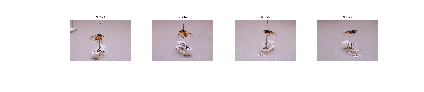

In [7]:
specimen = queue.specimens[0]
specimen.show()

## 1: correct perspective

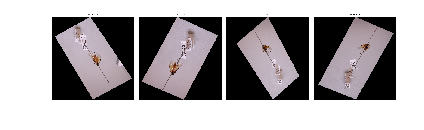

In [8]:
warped_specimen = perspective.specimen_warp(specimen)
warped_specimen.show()

## 2: find features

2018-10-30 19:07:16,069 DEBUG    found 3000 keypoints in view ALICE3
2018-10-30 19:07:16,124 DEBUG    removed 16 keypoints from view ALICE3
2018-10-30 19:07:28,124 DEBUG    found 3000 keypoints in view ALICE4
2018-10-30 19:07:28,172 DEBUG    removed 31 keypoints from view ALICE4
2018-10-30 19:07:40,095 DEBUG    found 3000 keypoints in view ALICE5
2018-10-30 19:07:40,141 DEBUG    removed 27 keypoints from view ALICE5
2018-10-30 19:07:52,093 DEBUG    found 3000 keypoints in view ALICE6
2018-10-30 19:07:52,134 DEBUG    removed 27 keypoints from view ALICE6
2018-10-30 19:07:52,177 DEBUG    removed 15 keypoints from view ALICE3
2018-10-30 19:07:52,225 DEBUG    removed 0 keypoints from view ALICE4
2018-10-30 19:07:52,271 DEBUG    removed 4 keypoints from view ALICE5
2018-10-30 19:07:52,321 DEBUG    removed 4 keypoints from view ALICE6
2018-10-30 19:07:54,202 DEBUG    89 common keypoints found
2018-10-30 19:08:06,378 DEBUG    found 4000 keypoints in view ALICE3
2018-10-30 19:08:06,449 DEBUG  

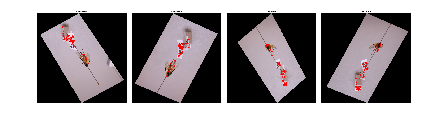

In [9]:
features_specimen = detection.specimen_find_features(warped_specimen)
features_specimen.show()

## 3: find labels

_The results of each run on a specimen are consistent up to this point - here the PEaRL method is used to find possible labels, and it may find something slightly different each time (or it may not find anything at all)._

2018-10-30 19:08:49,437 DEBUG    Completed iteration 0
2018-10-30 19:08:50,142 DEBUG    Completed iteration 1
2018-10-30 19:08:50,861 DEBUG    Completed iteration 2
2018-10-30 19:08:51,599 DEBUG    Completed iteration 3
2018-10-30 19:08:52,309 DEBUG    Completed iteration 4
2018-10-30 19:08:53,001 DEBUG    Completed iteration 5
2018-10-30 19:08:53,698 DEBUG    Completed iteration 6
2018-10-30 19:08:54,402 DEBUG    Completed iteration 7
2018-10-30 19:08:55,077 DEBUG    Completed iteration 8
2018-10-30 19:08:55,902 DEBUG    Completed iteration 9
2018-10-30 19:08:56,613 DEBUG    Completed iteration 10
2018-10-30 19:08:57,320 DEBUG    Completed iteration 11
2018-10-30 19:08:58,024 DEBUG    Completed iteration 12
2018-10-30 19:08:58,752 DEBUG    Completed iteration 13
2018-10-30 19:08:59,465 DEBUG    Completed iteration 14
2018-10-30 19:09:00,175 DEBUG    Completed iteration 15
2018-10-30 19:09:00,897 DEBUG    Completed iteration 16
2018-10-30 19:09:01,604 DEBUG    Completed iteration 17
20

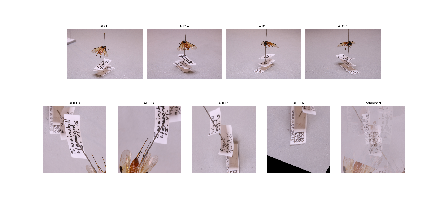

In [10]:
labels_specimen = detection.specimen_find_labels(features_specimen)
labels_specimen.show()

## 4: align labels

The exact solution is  x = 0                              


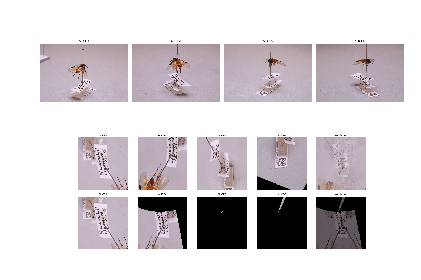

In [11]:
aligned_specimen = align.specimen_align_labels(labels_specimen)
aligned_specimen.show()

## 5: postprocess labels

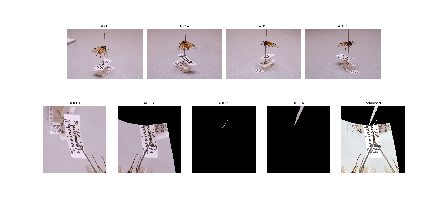

In [12]:
postprocess_specimen = postprocess.specimen_contrast_labels(aligned_specimen)
postprocess_specimen.show()

## end: save

This saves the whole display image with the original images on the top row and any labels in rows underneath:

In [13]:
postprocess_specimen.save(f'outputs/{specimen.id}.png')

To save individual labels:

In [14]:
for i, label in enumerate(postprocess_specimen.labels):
    label.save(f'outputs/{specimen.id}_label{i}.png')

---
## using a queue

Define a method running through the stages you want to use:

In [15]:
def _process(specimen):
    specimen = perspective.specimen_warp(specimen)
    specimen = detection.specimen_find_features(specimen)
    specimen = detection.specimen_find_labels(specimen)
    specimen = align.specimen_align_labels(specimen)
    specimen = postprocess.specimen_contrast_labels(specimen)
    specimen.save(f'outputs/{specimen.id}.png')
    del specimen  # to free up memory

And run it with `queue.try_process()`. This will try the method for each specimen, tolerating all errors (does not break, just moves on to the next specimen and retries later) and retrying up to 2 times for each failed specimen.

In [17]:
queue.try_process(_process)

2018-10-30 19:19:45,451 DEBUG    found 3000 keypoints in view ALICE3
2018-10-30 19:19:45,493 DEBUG    removed 16 keypoints from view ALICE3
2018-10-30 19:19:57,477 DEBUG    found 3000 keypoints in view ALICE4
2018-10-30 19:19:57,525 DEBUG    removed 31 keypoints from view ALICE4
2018-10-30 19:20:09,394 DEBUG    found 3000 keypoints in view ALICE5
2018-10-30 19:20:09,438 DEBUG    removed 27 keypoints from view ALICE5
2018-10-30 19:20:21,425 DEBUG    found 3000 keypoints in view ALICE6
2018-10-30 19:20:21,475 DEBUG    removed 27 keypoints from view ALICE6
2018-10-30 19:20:21,528 DEBUG    removed 15 keypoints from view ALICE3
2018-10-30 19:20:21,571 DEBUG    removed 0 keypoints from view ALICE4
2018-10-30 19:20:21,621 DEBUG    removed 4 keypoints from view ALICE5
2018-10-30 19:20:21,666 DEBUG    removed 4 keypoints from view ALICE6
2018-10-30 19:20:23,558 DEBUG    89 common keypoints found
2018-10-30 19:20:35,543 DEBUG    found 4000 keypoints in view ALICE3
2018-10-30 19:20:35,602 DEBUG  